<a href="https://colab.research.google.com/github/daniyal9538/GeneralProjects/blob/master/SELANI_aerial_cactus_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NOTE:
Even though training and test data was provided seperately, the test data is without labels, hence it could not be used to assertain the accuracy of the models

#Get Data

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c aerial-cactus-identification -p /content
!unzip \*.zip

#Get dependencies

In [0]:
import os
import cv2
import tensorflow as tf
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow import keras
from tensorflow.keras import Model, Input, optimizers
from PIL import Image
from sklearn.model_selection import train_test_split

#Prepare Data

In [0]:
  ids = pd.read_csv('../content/train.csv')
  train_pics = os.listdir("../content/train")

In [0]:
data = []
labels = []

for i in train_pics:
    try:
    
        image = cv2.imread("../content/train/"+i)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((64 , 64))
        
        data.append(np.array(resize_img))
        
        labels.append(ids[ids['id'] == i]['has_cactus'].values[0])
        
        
    except AttributeError:
        print('Error')

In [0]:
X = np.array(data)
Y = np.array(labels)

In [0]:
Y= to_categorical(Y)

In [0]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=10)

In [0]:
width = X_train[0].shape[1]
height = X_train[0].shape[0]
channels = X_train[0].shape[2]
classes = y_train[0].shape[0]

In [0]:
width, height, channels, classes

(64, 64, 3, 2)

#Fit data to CNN

Same model is used as was used by me in the malayria  identification problem

In [0]:
model = Sequential()
    
inputShape = (height, width, channels)
chanDim = -1

model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = inputShape))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization(axis = chanDim))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3,3), activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization(axis = chanDim))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3,3), activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization(axis = chanDim))
model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization(axis = chanDim))
model.add(Dropout(0.5))
model.add(Dense(classes, activation = 'softmax'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
CNN = model.fit(X_train, y_train, epochs = 20, batch_size = 32)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
14000/14000 [==============================] - 8s 580us/sample - loss: 0.2401 - acc: 0.9199
Epoch 2/20
14000/14000 [==============================] - 4s 293us/sample - loss: 0.1151 - acc: 0.9594
Epoch 3/20
14000/14000 [==============================] - 4s 272us/sample - loss: 0.0868 - acc: 0.9678
Epoch 4/20
14000/14000 [==============================] - 4s 271us/sample - loss: 0.0712 - acc: 0.9734
Epoch 5/20
14000/14000 [==============================] - 4s 270us/sample - loss: 0.0605 - acc: 0.9786
Epoch 6/20
14000/14000 [==============================] - 4s 273us/sample - loss: 0.0508 - acc: 0.9816
Epoch 7/20
14000/14000 [==============================] - 4s 270us/sample - loss: 0.0421 - acc: 0.9859
Epoch 8/20
14000/14000 [==============================] - 4s 270us/sample - loss: 0.0430 - acc: 0.9858
Epoch 9/20
14000/14000 [==============================] - 4s 271us/sample - loss: 0.0330 - acc: 0.9884
Epoch 10/20
14000/14000 [

Model perform extremely well

In [0]:
pred = model.evaluate(np.array(X_test), y_test)
'Validation Loss and Accuracy',pred

3500/3500 [==============================] - 0s 137us/sample - loss: 0.0230 - acc: 0.9906


('Validation Loss and Accuracy', [0.023012677410268224, 0.99057144])

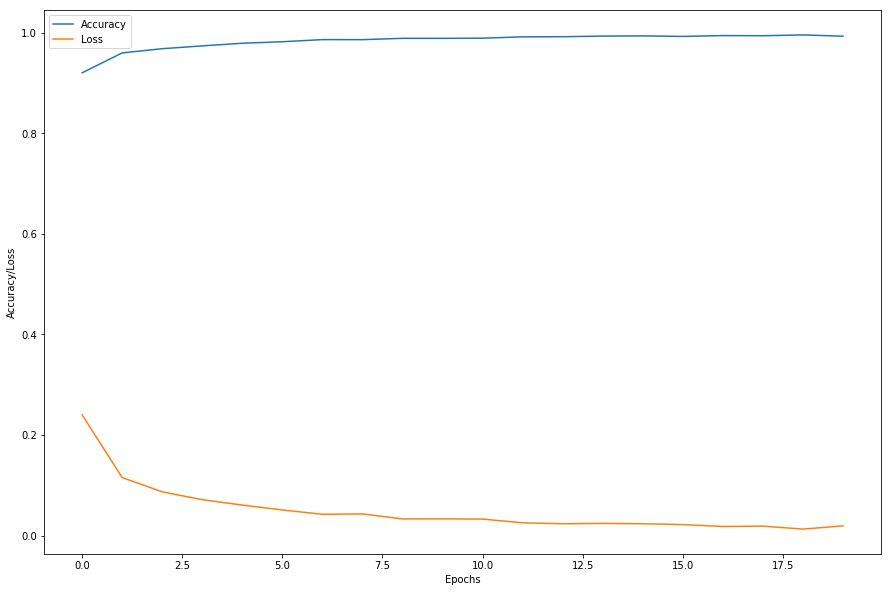

In [0]:
plt.figure(figsize = (15,10))
plt.plot(range(20), CNN.history['acc'], label = 'Accuracy')
plt.plot(range(20), CNN.history['loss'], label = 'Loss')
#ax1.set_xticks(np.arange(0, 31, 5))
plt.xlabel("Epochs")
plt.ylabel('Accuracy/Loss')

plt.legend(loc = "best")

#Transfer Learning

Wanted to use inception V3, input image to small for inception V3

In [0]:
vgg16 = keras.applications.vgg16.VGG16(include_top=False,input_shape = (height, width, channels))

Repeat same steps as done in the malayria identification problem

In [0]:
tmodel = Sequential()


for layer in vgg16.layers:
  tmodel.add(layer)
  
tmodel.layers.pop()

for layer in tmodel.layers:
  layer.Trainable = False
  
tmodel.add(Flatten())
tmodel.add(Dense(classes, activation = 'softmax'))

In [0]:
tmodel.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
transfer = tmodel.fit(X_train, y_train, epochs = 5, batch_size = 32)

Epoch 1/5
14000/14000 [==============================] - 27s 2ms/sample - loss: 4.0318 - acc: 0.7499
Epoch 2/5
14000/14000 [==============================] - 26s 2ms/sample - loss: 4.0318 - acc: 0.7499
Epoch 3/5
14000/14000 [==============================] - 26s 2ms/sample - loss: 4.0318 - acc: 0.7499
Epoch 4/5
14000/14000 [==============================] - 26s 2ms/sample - loss: 4.0318 - acc: 0.7499
Epoch 5/5
14000/14000 [==============================] - 26s 2ms/sample - loss: 4.0318 - acc: 0.7499


Transfer learning does not require so many epochs to be trained as most layers are already frozen. Model does not perform well
Probably not designed to work on such a dataset


In [0]:
pred = tmodel.evaluate(np.array(X_test), y_test)
'Validation Loss and Accuracy',pred

3500/3500 [==============================] - 3s 867us/sample - loss: 3.9697 - acc: 0.7537


('Validation Loss and Accuracy', [3.969656693322318, 0.75371426])

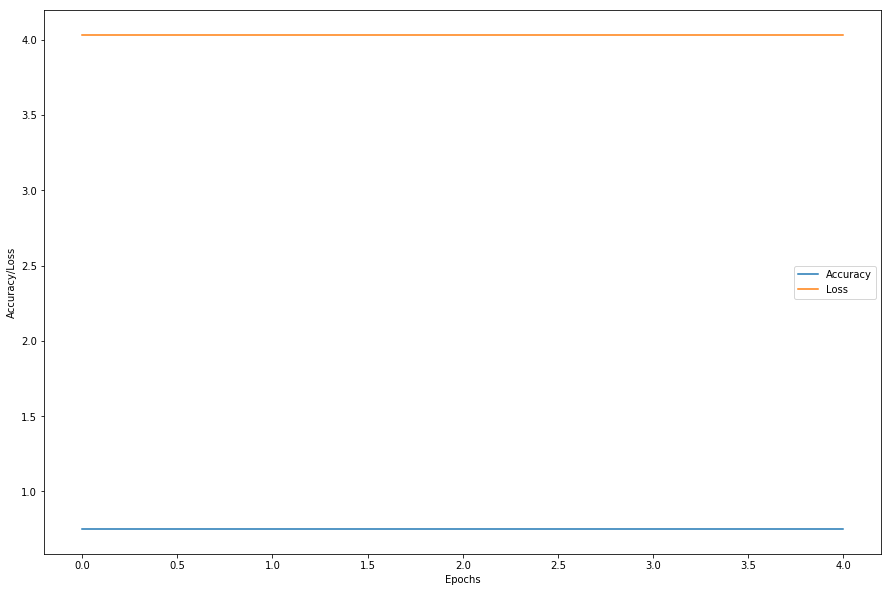

In [0]:
plt.figure(figsize = (15,10))
plt.plot(range(5), transfer.history['acc'], label = 'Accuracy')
plt.plot(range(5), transfer.history['loss'], label = 'Loss')
#ax1.set_xticks(np.arange(0, 31, 5))
plt.xlabel("Epochs")
plt.ylabel('Accuracy/Loss')

plt.legend(loc = "best")